<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Fira+Code&display=swap" rel="stylesheet">

### License

<p style="font-family: 'Fira Code', monospace; font-size: 1.2rem">
Copyright (C) 2025, Advanced Micro Devices, Inc.
<br><br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br><br>
You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0"?>http://www.apache.org/licenses/LICENSE-2.0</a><br><br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.<br>
</p>


# IBERT UltraScale-Plus GTY Example


### Description
This example shows how to use IBERT (Integrated Bit Error Ratio Tester) debug core service via ChipScoPy APIs with UltraScale-Plus GTY. The example shows following capabilities:
- Program a design on VCU128
- Verify that the expected IBERT quads are instantiated by the design
- Read/Write register properties from GTY Quad

### Requirements
- VCU128 Board
- Xilinx hw_server 2025.2 installed and running
- Xilinx cs_server 2025.2 installed and running
- Python 3.10 or greater installed
- ChipScoPy 2025.2 installed
- Jupyter notebook support installed - Please do so, using the command pip install chipscopy[jupyter]
- Plotting support installed - Please do so, using the command pip install chipscopy[core-addons]


## 1 - Initialization: Imports and File Paths

After this step,
- Required functions and classes are imported
- Paths to server(s) and files are set correctly

In [1]:
import os
from more_itertools import one
from itertools import product

from chipscopy import create_session, delete_session, report_versions, get_design_files, report_hierarchy
from chipscopy.api.ibert.aliases import (
    EYE_SCAN_HORZ_RANGE,
    EYE_SCAN_VERT_RANGE,
    EYE_SCAN_VERT_STEP,
    EYE_SCAN_HORZ_STEP,
    EYE_SCAN_TARGET_BER,
    PATTERN,
    RX_LOOPBACK,
    TX_PRE_CURSOR,
    TX_POST_CURSOR,
    TX_DIFFERENTIAL_SWING,
    RX_TERMINATION_VOLTAGE,
    RX_COMMON_MODE
)
from chipscopy.api.ibert import  create_links, create_eye_scans

In [2]:
# Make sure to start the hw_server and cs_server prior to running.
# Specify locations of the running hw_server and cs_server below.
# The default is localhost - but can be other locations on the network.
CS_URL = "TCP:localhost:3042"
HW_URL = "TCP:localhost:3121"


print(f"HW_URL: {HW_URL}")
print(f"CS_URL: {CS_URL}")

# The get_design_files() function tries to find the PDI and LTX files. In non-standard
# configurations, you can put the path for PROGRAMMING_FILE and PROBES_FILE below.
design_files = get_design_files("vcu128/example_design")

BIT_FILE = design_files.programming_file
print(BIT_FILE)

HW_URL: TCP:localhost:3121
CS_URL: TCP:localhost:3042
/scratch/chipscopy/chipscopy/examples/designs/vcu128/example_design/example_ibert_vcu128_q131_q132_q134_q135.bit


## 2 - Create a session and connect to the hw_server and cs_server

The session is a container that keeps track of devices and debug cores.
After this step,
- Session is initialized and connected to server(s)
- Versions are detected and reported to stdout

In [3]:
session = create_session(cs_server_url=CS_URL, hw_server_url=HW_URL)
report_versions(session)

                      ChipScoPy Version Information                      
┌────────────────────────────┬──────────────────────────────────────────┐
│                     Entity │ Version                                  │
├────────────────────────────┼──────────────────────────────────────────┤
│                  ChipScoPy │ ┌───────────┬──────────────────────┐     │
│                            │ │ Attribute │ Value                │     │
│                            │ ├───────────┼──────────────────────┤     │
│                            │ │     Build │ 2025.2.0.0           │     │
│                            │ │ Timestamp │ Dec 31 1969-16:00:00 │     │
│                            │ └───────────┴──────────────────────┘     │
│                            │                                          │
│ hw_server @ localhost:3121 │ ┌───────────┬───────────┐                │
│                            │ │ Attribute │ Value     │                │
│                            │ ├───────────┼───────────┤                │
│                            │ │    Status │ Connected │                │
│                            │ │     Build │ 0         │                │
│                            │ │   Version │ 2025.2    │                │
│                            │ │ Timestamp │           │                │
│                            │ └───────────┴───────────┘                │
│                            │                                          │
│ cs_server @ localhost:3042 │ ┌───────────────┬──────────────────────┐ │
│                            │ │     Attribute │ Value                │ │
│                            │ ├───────────────┼──────────────────────┤ │
│                            │ │        Status │ Connected            │ │
│                            │ │         Build │ 1762552890           │ │
│                            │ │       Version │ 2025.2.0             │ │
│                            │ │     Timestamp │ Nov 07 2025-14:01:30 │ │
│                            │ │       Package │ 2025.2.1762552890    │ │
│                            │ │ Artifact type │ pyinstaller          │ │
│                            │ └───────────────┴──────────────────────┘ │
└────────────────────────────┴──────────────────────────────────────────┘

## 3 - Program the device with the example design

After this step,
- Device is programmed with the example programming file

In [4]:
# Typical case - one device on the board - get it.
device = session.devices[0]
print(device)
device.program(BIT_FILE, delay_after_program = 10)



xcvu37p:19809458480293611750555681477:jsn-HW-U1-VCU128 FT4232H-091847100741A-14b79093-0


--> INFO: Programming device with: 
/scratch/chipscopy/chipscopy/examples/designs/vcu128/example_design/example_ibert_vcu128_q131_q132_q134_q135.bit

Output()

In [5]:
# Workaround for UltraScale+ devices...
# We need to close then reopen the session to force a rescanning of the nodes after programming.
delete_session(session)
session = create_session(cs_server_url=CS_URL, hw_server_url=HW_URL)
device = session.devices[0]

## 4 - Discover  IBERT cores

Debug core discovery initializes the chipscope server debug cores.

After this step,

- The cs_server is initialized and ready for use
- The first ibert found is used

In [6]:
device.discover_and_setup_cores(ibert_scan=True)
print("--> Debug core discovery done for board")

if len(device.ibert_cores) == 0:
    print("No IBERT core found with board 1! Exiting...")
    exit()

for ibert in device.ibert_cores:
    print(f"\n-> {ibert} ({ibert.handle})")

--> Debug core discovery done for board

-> IBERT UltraScale+ GTY (IBERT_0)

-> IBERT UltraScale+ GTY (IBERT_1)


## 5 - Discover all GT_Groups available under each IBERT Core

In [7]:
for ibert in device.ibert_cores:
    for gt_group in ibert.gt_groups:
        print(f"GT Groups available with {ibert.handle} - {[gt_group_obj.name for gt_group_obj in ibert.gt_groups]}")

GT Groups available with IBERT_0 - ['Quad_131', 'Quad_132']
GT Groups available with IBERT_0 - ['Quad_131', 'Quad_132']
GT Groups available with IBERT_1 - ['Quad_134', 'Quad_135']
GT Groups available with IBERT_1 - ['Quad_134', 'Quad_135']


## 6 - Print Hierarchy for each IBERT Core

In [8]:
for ibert in device.ibert_cores:
    report_hierarchy(ibert)

IBERT UltraScale+ GTY
├── Quad_131
│   ├── COMMON_X0Y7
│   │   ├── QPLL_0
│   │   └── QPLL_1
│   ├── MGT_X0Y28
│   │   ├── CPLL_0
│   │   ├── TX
│   │   └── RX
│   ├── MGT_X0Y29
│   │   ├── CPLL_0
│   │   ├── TX
│   │   └── RX
│   ├── MGT_X0Y30
│   │   ├── CPLL_0
│   │   ├── TX
│   │   └── RX
│   └── MGT_X0Y31
│       ├── CPLL_0
│       ├── TX
│       └── RX
└── Quad_132
    ├── COMMON_X0Y8
    │   ├── QPLL_0
    │   └── QPLL_1
    ├── MGT_X0Y32
    │   ├── CPLL_0
    │   ├── TX
    │   └── RX
    ├── MGT_X0Y33
    │   ├── CPLL_0
    │   ├── TX
    │   └── RX
    ├── MGT_X0Y34
    │   ├── CPLL_0
    │   ├── TX
    │   └── RX
    └── MGT_X0Y35
        ├── CPLL_0
        ├── TX
        └── RX

IBERT UltraScale+ GTY
├── Quad_134
│   ├── COMMON_X0Y10
│   │   ├── QPLL_0
│   │   └── QPLL_1
│   ├── MGT_X0Y40
│   │   ├── CPLL_0
│   │   ├── TX
│   │   └── RX
│   ├── MGT_X0Y41
│   │   ├── CPLL_0
│   │   ├── TX
│   │   └── RX
│   ├── MGT_X0Y42
│   │   ├── CPLL_0
│   │   ├── TX
│   │   └── RX
│   └── MGT_X0Y43
│       ├── CPLL_0
│       ├── TX
│       └── RX
└── Quad_135
    ├── COMMON_X0Y11
    │   ├── QPLL_0
    │   └── QPLL_1
    ├── MGT_X0Y44
    │   ├── CPLL_0
    │   ├── TX
    │   └── RX
    ├── MGT_X0Y45
    │   ├── CPLL_0
    │   ├── TX
    │   └── RX
    ├── MGT_X0Y46
    │   ├── CPLL_0
    │   ├── TX
    │   └── RX
    └── MGT_X0Y47
        ├── CPLL_0
        ├── TX
        └── RX

## 7 - Find all GT and GT_COMMON nodes under each GT Group

In [9]:
for ibert in device.ibert_cores:
    for child in gt_group.children:
        print(f"name = {child.name}")
        print(f"type = {child.type}")
        print(f"setup_done = {child.setup_done}")
        print(f"children = {child.children}")

name = COMMON_X0Y11
type = GT_COMMON
setup_done = True
children = [
    'IBERT_1.Quad_135.COMMON_X0Y11.QPLL_0(PLL/QPLL0)',
    'IBERT_1.Quad_135.COMMON_X0Y11.QPLL_1(PLL/QPLL1)'
]
name = MGT_X0Y44
type = GT
setup_done = True
children = [
    'IBERT_1.Quad_135.MGT_X0Y44.CPLL_0(PLL/CPLL0)',
    'IBERT_1.Quad_135.MGT_X0Y44.TX(TX)',
    'IBERT_1.Quad_135.MGT_X0Y44.RX(RX)'
]
name = MGT_X0Y45
type = GT
setup_done = True
children = [
    'IBERT_1.Quad_135.MGT_X0Y45.CPLL_0(PLL/CPLL0)',
    'IBERT_1.Quad_135.MGT_X0Y45.TX(TX)',
    'IBERT_1.Quad_135.MGT_X0Y45.RX(RX)'
]
name = MGT_X0Y46
type = GT
setup_done = True
children = [
    'IBERT_1.Quad_135.MGT_X0Y46.CPLL_0(PLL/CPLL0)',
    'IBERT_1.Quad_135.MGT_X0Y46.TX(TX)',
    'IBERT_1.Quad_135.MGT_X0Y46.RX(RX)'
]
name = MGT_X0Y47
type = GT
setup_done = True
children = [
    'IBERT_1.Quad_135.MGT_X0Y47.CPLL_0(PLL/CPLL0)',
    'IBERT_1.Quad_135.MGT_X0Y47.TX(TX)',
    'IBERT_1.Quad_135.MGT_X0Y47.RX(RX)'
]
name = COMMON_X0Y11
type = GT_COMMON
setup_done =

## 8 - Select a GT Group to work with

In [10]:
# Use the first available IBERT core from the device
ibert = device.ibert_cores.at(index=0)

if len(ibert.gt_groups) == 0:
    print("No GT Groups available for use! Exiting...")
    exit()

q131 = one(ibert.gt_groups.filter_by(name="Quad_131"))
print(f"q131 ->-> {gt_group.name} | {gt_group.handle} | {gt_group.type}")

q131 ->-> Quad_135 | IBERT_1.Quad_135 | GT_Group


## 9 - Create links between following TXs and RXs
- Quad 131 CH0 TX to Quad 131 CH0 RX
- Quad 131 CH1 TX to Quad 131 CH1 RX
- Quad 131 CH2 TX to Quad 131 CH2 RX
- Quad 131 CH3 TX to Quad 131 CH3 RX

In [11]:
links = create_links(
    txs=[q131.gts[0].tx, q131.gts[1].tx, q131.gts[2].tx, q131.gts[3].tx],
    rxs=[q131.gts[0].rx, q131.gts[1].rx, q131.gts[2].rx, q131.gts[3].rx],
)

## 10 - Print the valid values for pattern and loopback, set the pattern for the TXs and RXs to "PRBS 31" and set loopback to "Near-End PMA"

In order to lock the internal pattern checker, TX and RX patterns need to match. We also need to have some kind of loopback, internal/external.

We are assuming that no external cable loopback is present and hence making use of internal loopback.

In [12]:
for link in links:
    print(f"\n----- {link.name} -----")
    _, tx_pattern_report = link.tx.property.report(link.tx.property_for_alias[PATTERN]).popitem()
    _, rx_pattern_report = link.rx.property.report(link.rx.property_for_alias[PATTERN]).popitem()
    _, rx_loopback_report = link.tx.property.report(
        link.rx.property_for_alias[RX_LOOPBACK]
    ).popitem()

    print(f"--> Valid values for TX pattern - {tx_pattern_report['Valid values']}")
    print(f"--> Valid values for RX pattern - {rx_pattern_report['Valid values']}")
    print(f"--> Valid values for RX loopback - {rx_loopback_report['Valid values']}")

    props = {link.tx.property_for_alias[PATTERN]: "PRBS 31"}
    link.tx.property.set(**props)
    link.tx.property.commit(list(props.keys()))

    props = {
        link.rx.property_for_alias[PATTERN]: "PRBS 31",
        link.rx.property_for_alias[RX_LOOPBACK]: "Near-End PMA",
    }
    link.rx.property.set(**props)
    link.rx.property.commit(list(props.keys()))
    print(f"\n--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for {link}")

    print(f"link.rx.pll.locked = {link.rx.pll.locked} and link.tx.pll.locked = {link.tx.pll.locked}")

    print(f"link.status= {link.status}")

    link.generate_report()


----- Link_0 -----
--> Valid values for TX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX loopback - ['None', 'Near-End PCS', 'Near-End PMA', 'Far-End PMA', 'Far-End PCS']

--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for Link_0
link.rx.pll.locked = True and link.tx.pll.locked = True
link.status= 25.0 Gbps


 Link "IBERT_0.Quad_131.MGT_X0Y28.TX-->IBERT_0.Quad_131.MGT_X0Y28.RX" 
                                report                                
┌────────────────────────────────────┬───────────────────────────────┐
│                           Property │ Value                         │
├────────────────────────────────────┼───────────────────────────────┤
│                               Name │ Link_0                        │
│                                 RX │ IBERT_0.Quad_131.MGT_X0Y28.RX │
│                                 TX │ IBERT_0.Quad_131.MGT_X0Y28.TX │
│                         Link Group │ None                          │
│                                    │                               │
│                             RX BER │ 1.709866e-04                  │
│                          RX Status │ 25.0 Gbps                     │
│                         RX Pattern │ PRBS 31                       │
│                        RX Loopback │ Near-End PMA                  │
│                     RX RX Polarity │ 0x0                           │
│                        RX PLL Type │ QPLL0                         │
│                      RX PLL Source │ QPLL_0                        │
│                           RX Reset │ N/A                           │
│                    RX RX BER Reset │ N/A                           │
│                      RX Data Width │ 80                            │
│             RX Internal Data Width │ 2                             │
│           RX USRCLK Frequency Tune │ 0x4000                        │
│          RX USRCLK2 Frequency Tune │ 0x4000                        │
│          RX USRCLK Frequency Count │ 0x3200                        │
│         RX USRCLK2 Frequency Count │ 0x3200                        │
│                     RX DFE Enabled │ Yes                           │
│                     RX Common Mode │ PROGRAMMABLE                  │
│             RX Termination Voltage │ 800 mV                        │
│     RX Pattern Checker Error Count │ 0x98A_9469                    │
│  RX First read rx_word count value │ 0x0002_B8FD_8927              │
│ RX Second read rx_word count value │ 0x0002_B940_97E7              │
│          RX First read timer value │ 0x0000_DF0F_D167              │
│         RX Second read timer value │ 0x0000_DF25_46CA              │
│             RX sys clock Frequency │ 100.0 MHz                     │
│             RX RX USRCLK Frequency │ 312.549 MHz                   │
│            RX RX USRCLK2 Frequency │ 312.549 MHz                   │
│                       RX Line Rate │ 25.0 Gbps                     │
│     RX Pattern Checker Lock Status │ 0x1                           │
│     RX Pattern Checker Cycle Count │ 0x2_B985_19FC                 │
│              RX Received Bit Count │ 2.328839e+10                  │
│                                    │                               │
│                         TX Pattern │ PRBS 31                       │
│                           TX Reset │ N/A                           │
│                     TX TX Polarity │ 0x0                           │
│                        TX PLL Type │ QPLL0                         │
│                    TX Inject Error │ N/A                           │
│                      TX PLL Source │ QPLL_0                        │
│                      TX Pre Cursor │ 0.01 dB                       │
│                      TX Data Width │ 80                            │
│                     TX Post Cursor │ 0.00 dB                       │
│            TX Differential Control │ 950 mV                        │
│          TX USRCLK Frequency Count │ 0x3200                        │
│           TX USRCLK Frequency Tune │ 0x4000                        │
│         TX USRCLK2 Frequency Count │ 0x3200                        │
│          TX USRCLK2 Frequency Tune │ 0x4000                        │
│             TX TX USRCLK Frequency │ 312.549 MHz                   │
│            TX TX USRCL


----- Link_1 -----
--> Valid values for TX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX loopback - ['None', 'Near-End PCS', 'Near-End PMA', 'Far-End PMA', 'Far-End PCS']

--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for Link_1
link.rx.pll.locked = True and link.tx.pll.locked = True
link.status= 25.0 Gbps


 Link "IBERT_0.Quad_131.MGT_X0Y29.TX-->IBERT_0.Quad_131.MGT_X0Y29.RX" 
                                report                                
┌────────────────────────────────────┬───────────────────────────────┐
│                           Property │ Value                         │
├────────────────────────────────────┼───────────────────────────────┤
│                               Name │ Link_1                        │
│                                 RX │ IBERT_0.Quad_131.MGT_X0Y29.RX │
│                                 TX │ IBERT_0.Quad_131.MGT_X0Y29.TX │
│                         Link Group │ None                          │
│                                    │                               │
│                             RX BER │ 8.354048e-05                  │
│                          RX Status │ 25.0 Gbps                     │
│                         RX Pattern │ PRBS 31                       │
│                        RX Loopback │ Near-End PMA                  │
│                     RX RX Polarity │ 0x0                           │
│                        RX PLL Type │ QPLL0                         │
│                      RX PLL Source │ QPLL_0                        │
│                           RX Reset │ N/A                           │
│                    RX RX BER Reset │ N/A                           │
│                      RX Data Width │ 80                            │
│             RX Internal Data Width │ 2                             │
│           RX USRCLK Frequency Tune │ 0x4000                        │
│          RX USRCLK2 Frequency Tune │ 0x4000                        │
│          RX USRCLK Frequency Count │ 0x3200                        │
│         RX USRCLK2 Frequency Count │ 0x3200                        │
│                     RX DFE Enabled │ Yes                           │
│                     RX Common Mode │ PROGRAMMABLE                  │
│             RX Termination Voltage │ 800 mV                        │
│     RX Pattern Checker Error Count │ 0x4C8_C9CF                    │
│  RX First read rx_word count value │ 0x0002_CAF9_BF8A              │
│ RX Second read rx_word count value │ 0x0002_CB41_8359              │
│          RX First read timer value │ 0x0000_E4D1_2C5F              │
│         RX Second read timer value │ 0x0000_E4E8_2361              │
│             RX sys clock Frequency │ 100.0 MHz                     │
│             RX RX USRCLK Frequency │ 312.549 MHz                   │
│            RX RX USRCLK2 Frequency │ 312.549 MHz                   │
│                       RX Line Rate │ 25.0 Gbps                     │
│     RX Pattern Checker Lock Status │ 0x1                           │
│     RX Pattern Checker Cycle Count │ 0x2_CBDE_B430                 │
│              RX Received Bit Count │ 2.389540e+10                  │
│                                    │                               │
│                         TX Pattern │ PRBS 31                       │
│                           TX Reset │ N/A                           │
│                     TX TX Polarity │ 0x0                           │
│                        TX PLL Type │ QPLL0                         │
│                    TX Inject Error │ N/A                           │
│                      TX PLL Source │ QPLL_0                        │
│                      TX Pre Cursor │ 0.01 dB                       │
│                      TX Data Width │ 80                            │
│                     TX Post Cursor │ 0.00 dB                       │
│            TX Differential Control │ 950 mV                        │
│          TX USRCLK Frequency Count │ 0x3200                        │
│           TX USRCLK Frequency Tune │ 0x4000                        │
│         TX USRCLK2 Frequency Count │ 0x3200                        │
│          TX USRCLK2 Frequency Tune │ 0x4000                        │
│             TX TX USRCLK Frequency │ 312.549 MHz                   │
│            TX TX USRCL


----- Link_2 -----
--> Valid values for TX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX loopback - ['None', 'Near-End PCS', 'Near-End PMA', 'Far-End PMA', 'Far-End PCS']

--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for Link_2
link.rx.pll.locked = True and link.tx.pll.locked = True
link.status= 25.0 Gbps


 Link "IBERT_0.Quad_131.MGT_X0Y30.TX-->IBERT_0.Quad_131.MGT_X0Y30.RX" 
                                report                                
┌────────────────────────────────────┬───────────────────────────────┐
│                           Property │ Value                         │
├────────────────────────────────────┼───────────────────────────────┤
│                               Name │ Link_2                        │
│                                 RX │ IBERT_0.Quad_131.MGT_X0Y30.RX │
│                                 TX │ IBERT_0.Quad_131.MGT_X0Y30.TX │
│                         Link Group │ None                          │
│                                    │                               │
│                             RX BER │ 3.441118e-04                  │
│                          RX Status │ 25.0 Gbps                     │
│                         RX Pattern │ PRBS 31                       │
│                        RX Loopback │ Near-End PMA                  │
│                     RX RX Polarity │ 0x0                           │
│                        RX PLL Type │ QPLL0                         │
│                      RX PLL Source │ QPLL_0                        │
│                           RX Reset │ N/A                           │
│                    RX RX BER Reset │ N/A                           │
│                      RX Data Width │ 80                            │
│             RX Internal Data Width │ 2                             │
│           RX USRCLK Frequency Tune │ 0x4000                        │
│          RX USRCLK2 Frequency Tune │ 0x4000                        │
│          RX USRCLK Frequency Count │ 0x3200                        │
│         RX USRCLK2 Frequency Count │ 0x3200                        │
│                     RX DFE Enabled │ Yes                           │
│                     RX Common Mode │ PROGRAMMABLE                  │
│             RX Termination Voltage │ 800 mV                        │
│     RX Pattern Checker Error Count │ 0x1444_7BB1                   │
│  RX First read rx_word count value │ 0x0002_DF5B_52B0              │
│ RX Second read rx_word count value │ 0x0002_DF9E_4A44              │
│          RX First read timer value │ 0x0000_EB56_CBD9              │
│         RX Second read timer value │ 0x0000_EB6C_39CA              │
│             RX sys clock Frequency │ 100.0 MHz                     │
│             RX RX USRCLK Frequency │ 312.549 MHz                   │
│            RX RX USRCLK2 Frequency │ 312.549 MHz                   │
│                       RX Line Rate │ 25.0 Gbps                     │
│     RX Pattern Checker Lock Status │ 0x1                           │
│     RX Pattern Checker Cycle Count │ 0x2_E039_B853                 │
│              RX Received Bit Count │ 2.458359e+10                  │
│                                    │                               │
│                         TX Pattern │ PRBS 31                       │
│                           TX Reset │ N/A                           │
│                     TX TX Polarity │ 0x0                           │
│                        TX PLL Type │ QPLL0                         │
│                    TX Inject Error │ N/A                           │
│                      TX PLL Source │ QPLL_0                        │
│                      TX Pre Cursor │ 0.01 dB                       │
│                      TX Data Width │ 80                            │
│                     TX Post Cursor │ 0.00 dB                       │
│            TX Differential Control │ 950 mV                        │
│          TX USRCLK Frequency Count │ 0x3200                        │
│           TX USRCLK Frequency Tune │ 0x4000                        │
│         TX USRCLK2 Frequency Count │ 0x3200                        │
│          TX USRCLK2 Frequency Tune │ 0x4000                        │
│             TX TX USRCLK Frequency │ 312.549 MHz                   │
│            TX TX USRCL


----- Link_3 -----
--> Valid values for TX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX pattern - ['PRBS 7', 'PRBS 9', 'PRBS 15', 'PRBS 23', 'PRBS 31', 'FAST CLK', 'SLOW CLK']
--> Valid values for RX loopback - ['None', 'Near-End PCS', 'Near-End PMA', 'Far-End PMA', 'Far-End PCS']

--> Set both patterns to 'PRBS 31' & loopback to 'Near-End PMA' for Link_3
link.rx.pll.locked = True and link.tx.pll.locked = True
link.status= 25.0 Gbps


 Link "IBERT_0.Quad_131.MGT_X0Y31.TX-->IBERT_0.Quad_131.MGT_X0Y31.RX" 
                                report                                
┌────────────────────────────────────┬───────────────────────────────┐
│                           Property │ Value                         │
├────────────────────────────────────┼───────────────────────────────┤
│                               Name │ Link_3                        │
│                                 RX │ IBERT_0.Quad_131.MGT_X0Y31.RX │
│                                 TX │ IBERT_0.Quad_131.MGT_X0Y31.TX │
│                         Link Group │ None                          │
│                                    │                               │
│                             RX BER │ 1.122026e-04                  │
│                          RX Status │ 25.0 Gbps                     │
│                         RX Pattern │ PRBS 31                       │
│                        RX Loopback │ Near-End PMA                  │
│                     RX RX Polarity │ 0x0                           │
│                        RX PLL Type │ QPLL0                         │
│                      RX PLL Source │ QPLL_0                        │
│                           RX Reset │ N/A                           │
│                    RX RX BER Reset │ N/A                           │
│                      RX Data Width │ 80                            │
│             RX Internal Data Width │ 2                             │
│           RX USRCLK Frequency Tune │ 0x4000                        │
│          RX USRCLK2 Frequency Tune │ 0x4000                        │
│          RX USRCLK Frequency Count │ 0x3200                        │
│         RX USRCLK2 Frequency Count │ 0x3200                        │
│                     RX DFE Enabled │ Yes                           │
│                     RX Common Mode │ PROGRAMMABLE                  │
│             RX Termination Voltage │ 800 mV                        │
│     RX Pattern Checker Error Count │ 0x6C9_F0C1                    │
│  RX First read rx_word count value │ 0x0002_F376_3B85              │
│ RX Second read rx_word count value │ 0x0002_F40E_46C3              │
│          RX First read timer value │ 0x0000_F1C5_D0C7              │
│         RX Second read timer value │ 0x0000_F1F6_7847              │
│             RX sys clock Frequency │ 100.0 MHz                     │
│             RX RX USRCLK Frequency │ 312.549 MHz                   │
│            RX RX USRCLK2 Frequency │ 312.549 MHz                   │
│                       RX Line Rate │ 25.0 Gbps                     │
│     RX Pattern Checker Lock Status │ 0x1                           │
│     RX Pattern Checker Cycle Count │ 0x2_F450_5C3E                 │
│              RX Received Bit Count │ 2.525594e+10                  │
│                                    │                               │
│                         TX Pattern │ PRBS 31                       │
│                           TX Reset │ N/A                           │
│                     TX TX Polarity │ 0x0                           │
│                        TX PLL Type │ QPLL0                         │
│                    TX Inject Error │ N/A                           │
│                      TX PLL Source │ QPLL_0                        │
│                      TX Pre Cursor │ 0.01 dB                       │
│                      TX Data Width │ 80                            │
│                     TX Post Cursor │ 0.00 dB                       │
│            TX Differential Control │ 950 mV                        │
│          TX USRCLK Frequency Count │ 0x3200                        │
│           TX USRCLK Frequency Tune │ 0x4000                        │
│         TX USRCLK2 Frequency Count │ 0x3200                        │
│          TX USRCLK2 Frequency Tune │ 0x4000                        │
│             TX TX USRCLK Frequency │ 312.549 MHz                   │
│            TX TX USRCL

## 11 - Create eye scan objects for all the links, set the scan params and start the scan

The eye scans will be run in parallel

In [13]:
eye_scans = create_eye_scans(target_objs=[link for link in links])
for eye_scan in eye_scans:
    print (eye_scan.name)

EyeScan_1
EyeScan_2
EyeScan_3
EyeScan_4


## 12 - Start eye scans for all the links

In [14]:
for eye_scan in eye_scans:
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 8
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 8
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5

    eye_scan.start()
    print(f"Started eye scan {eye_scan}")

Output()

Started eye scan EyeScan_1

Started eye scan EyeScan_2

Started eye scan EyeScan_3

Started eye scan EyeScan_4

## 13 - Wait for all the eye scans to get done

In [15]:
for eye_scan in eye_scans:
    eye_scan.wait_till_done()

## 14 - View Eye Scan Plot.

This requires Plotly to be installed. See how to install it [here](https://xilinx.github.io/chipscopy/2020.2/ibert/scan.html#scan-plots)

NOTE - The plot may not display if this notebook is run in Jupyter Lab. For details, see [link](https://plotly.com/python/getting-started/#jupyterlab-support-python-35)

In [16]:
for eye_scan in eye_scans:
    eye_scan.generate_report()

                            EyeScan_1 report                            
┌───────────────────────┬──────────────────────────────────────────────┐
│              Property │ Value                                        │
├───────────────────────┼──────────────────────────────────────────────┤
│                    RX │ IBERT_0.Quad_131.MGT_X0Y28.RX                │
│                Status │ Done                                         │
│              Progress │ 100.0%                                       │
│            Start time │ 2025-11-14 15:41:49.499026                   │
│             Stop time │ 2025-11-14 15:41:52.304291                   │
│        MB ELF version │ 0xB                                          │
│ #Data points expected │ 558                                          │
│     #Data points read │ 558                                          │
│                       │                                              │
│       Scan parameters │ ┌──────────────────┬───────────────────────┐ │
│                       │ │        Parameter │ Value                 │ │
│                       │ ├──────────────────┼───────────────────────┤ │
│                       │ │  Horizontal Step │ 8                     │ │
│                       │ │    Vertical Step │ 8                     │ │
│                       │ │ Horizontal Range │ -0.500 UI to 0.500 UI │ │
│                       │ │   Vertical Range │ 100%                  │ │
│                       │ │        Dwell BER │ 1e-05                 │ │
│                       │ │       Dwell Time │ 0                     │ │
│                       │ └──────────────────┴───────────────────────┘ │
└───────────────────────┴──────────────────────────────────────────────┘

                            EyeScan_2 report                            
┌───────────────────────┬──────────────────────────────────────────────┐
│              Property │ Value                                        │
├───────────────────────┼──────────────────────────────────────────────┤
│                    RX │ IBERT_0.Quad_131.MGT_X0Y29.RX                │
│                Status │ Done                                         │
│              Progress │ 100.0%                                       │
│            Start time │ 2025-11-14 15:41:49.727251                   │
│             Stop time │ 2025-11-14 15:41:53.295188                   │
│        MB ELF version │ 0xB                                          │
│ #Data points expected │ 558                                          │
│     #Data points read │ 558                                          │
│                       │                                              │
│       Scan parameters │ ┌──────────────────┬───────────────────────┐ │
│                       │ │        Parameter │ Value                 │ │
│                       │ ├──────────────────┼───────────────────────┤ │
│                       │ │  Horizontal Step │ 8                     │ │
│                       │ │    Vertical Step │ 8                     │ │
│                       │ │ Horizontal Range │ -0.500 UI to 0.500 UI │ │
│                       │ │   Vertical Range │ 100%                  │ │
│                       │ │        Dwell BER │ 1e-05                 │ │
│                       │ │       Dwell Time │ 0                     │ │
│                       │ └──────────────────┴───────────────────────┘ │
└───────────────────────┴──────────────────────────────────────────────┘

                            EyeScan_3 report                            
┌───────────────────────┬──────────────────────────────────────────────┐
│              Property │ Value                                        │
├───────────────────────┼──────────────────────────────────────────────┤
│                    RX │ IBERT_0.Quad_131.MGT_X0Y30.RX                │
│                Status │ Done                                         │
│              Progress │ 100.0%                                       │
│            Start time │ 2025-11-14 15:41:53.368441                   │
│             Stop time │ 2025-11-14 15:41:56.259494                   │
│        MB ELF version │ 0xB                                          │
│ #Data points expected │ 558                                          │
│     #Data points read │ 558                                          │
│                       │                                              │
│       Scan parameters │ ┌──────────────────┬───────────────────────┐ │
│                       │ │        Parameter │ Value                 │ │
│                       │ ├──────────────────┼───────────────────────┤ │
│                       │ │  Horizontal Step │ 8                     │ │
│                       │ │    Vertical Step │ 8                     │ │
│                       │ │ Horizontal Range │ -0.500 UI to 0.500 UI │ │
│                       │ │   Vertical Range │ 100%                  │ │
│                       │ │        Dwell BER │ 1e-05                 │ │
│                       │ │       Dwell Time │ 0                     │ │
│                       │ └──────────────────┴───────────────────────┘ │
└───────────────────────┴──────────────────────────────────────────────┘

                            EyeScan_4 report                            
┌───────────────────────┬──────────────────────────────────────────────┐
│              Property │ Value                                        │
├───────────────────────┼──────────────────────────────────────────────┤
│                    RX │ IBERT_0.Quad_131.MGT_X0Y31.RX                │
│                Status │ Done                                         │
│              Progress │ 100.0%                                       │
│            Start time │ 2025-11-14 15:41:53.574321                   │
│             Stop time │ 2025-11-14 15:41:57.136340                   │
│        MB ELF version │ 0xB                                          │
│ #Data points expected │ 558                                          │
│     #Data points read │ 558                                          │
│                       │                                              │
│       Scan parameters │ ┌──────────────────┬───────────────────────┐ │
│                       │ │        Parameter │ Value                 │ │
│                       │ ├──────────────────┼───────────────────────┤ │
│                       │ │  Horizontal Step │ 8                     │ │
│                       │ │    Vertical Step │ 8                     │ │
│                       │ │ Horizontal Range │ -0.500 UI to 0.500 UI │ │
│                       │ │   Vertical Range │ 100%                  │ │
│                       │ │        Dwell BER │ 1e-05                 │ │
│                       │ │       Dwell Time │ 0                     │ │
│                       │ └──────────────────┴───────────────────────┘ │
└───────────────────────┴──────────────────────────────────────────────┘

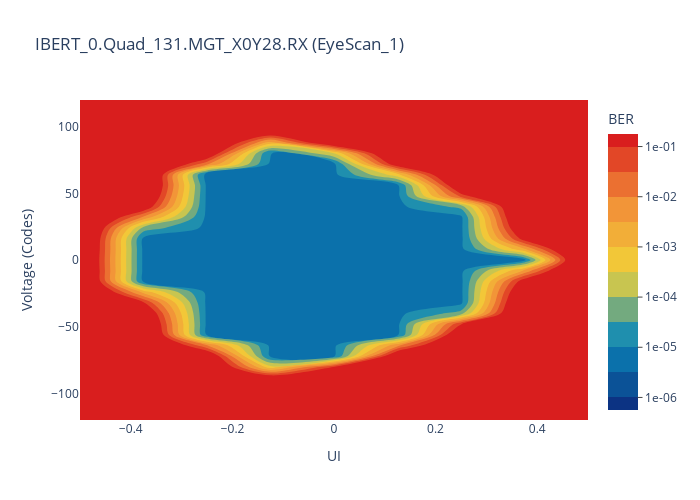

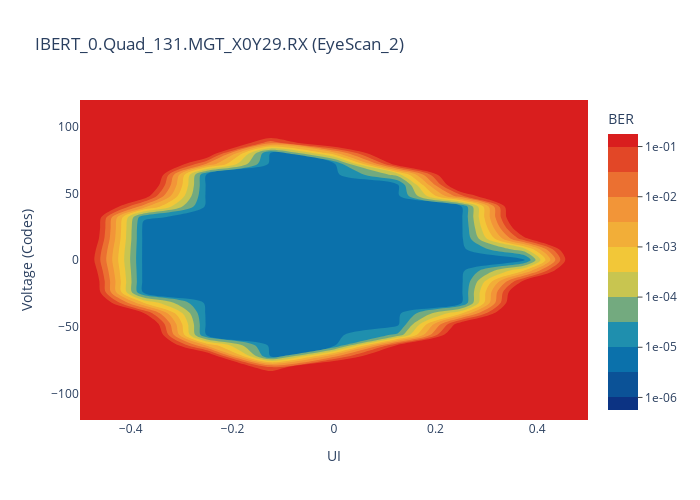

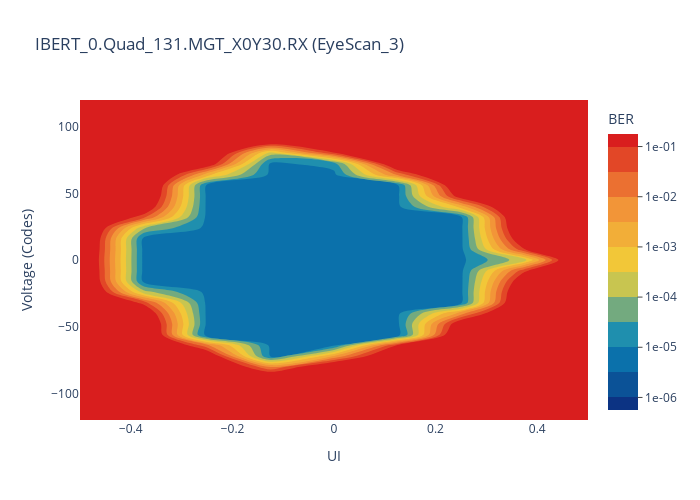

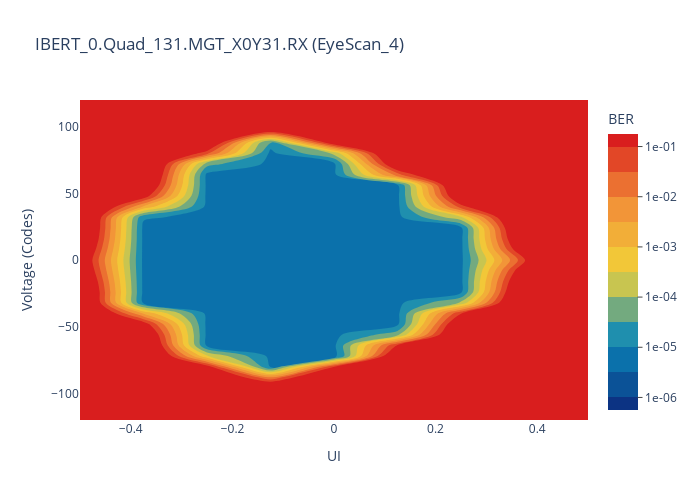

In [17]:
for eye_scan in eye_scans:
    eye_scan.plot.show()

In [18]:
for eye_scan in eye_scans:
    print(f"{eye_scan.name} Open Area: {eye_scan.metric_data.open_area}")

EyeScan_1 Open Area: 6592
EyeScan_2 Open Area: 6912
EyeScan_3 Open Area: 6400
EyeScan_4 Open Area: 6912
